In [1]:
import cv2
import random
import numpy as np
import os
sift = cv2.SIFT_create(nfeatures=100,contrastThreshold=0.01,nOctaveLayers=5)
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
import pickle
from sklearn import svm
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:


dico = []


def load_dataset():
    i=-1
    labels = []
    Data=[]
    paths =[ r'Corrected/Marhey',r'Corrected/Lemonada',r'Corrected/IBM Plex Sans Arabic',r'Corrected/Scheherazade New']
   
   
    for path in paths:
        img_filenames = os.listdir(path)
        i=i+1
        for  fn in tqdm(img_filenames):
            img_path = os.path.join(path, fn)
            img = cv2.imread(img_path)
            Data.append(img)
            labels.append(i)
    return Data,labels
Data,labels=load_dataset() 
X_train, X_test, y_train, y_test = train_test_split(Data, labels, test_size=0.2, random_state=42)
for img in tqdm(X_train):
    kp, des = sift.detectAndCompute(img, None)
    if(des is not None):
            for d in des:
                dico.append(d)

100%|██████████| 3197/3197 [28:44<00:00,  1.85it/s] 


In [3]:
k = 1600
kmeans = MiniBatchKMeans(n_clusters=k, verbose=1).fit(dico)
with open( 'kmeans.pkl', 'wb') as file:
          pickle.dump(kmeans, file)

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Init 1/3 with method k-means++
Inertia for init 1/3: 85783972.0
Init 2/3 with method k-means++
Inertia for init 2/3: 85263067.0
Init 3/3 with method k-means++
Inertia for init 3/3: 84365642.0
[MiniBatchKMeans] Reassigning 512 cluster centers.
Minibatch step 1/31498: mean batch inertia: 27158.08984375
[MiniBatchKMeans] Reassigning 512 cluster centers.
Minibatch step 2/31498: mean batch inertia: 29504.518291658733, ewa inertia: 29504.518291658733
[MiniBatchKMeans] Reassigning 456 cluster centers.
Minibatch step 3/31498: mean batch inertia: 28329.619237889136, ewa inertia: 29497.058221956027
Minibatch step 4/31498: mean batch inertia: 26627.022550967336, ewa inertia: 29478.834812816207
Minibatch step 5/31498: mean batch inertia: 27487.420353307883, ewa inertia: 29466.190245074627
Minibatch step 6/31498: mean batch inertia: 25534.244092337314, ewa inertia: 29441.22419180171
Minibatch step 7/31498: mean batch inertia: 24328.20366569667, ewa inertia: 29408.758858381163
Minibatch step 8/31498

In [4]:
histo_list = []
kmeans.verbose = False


for img in tqdm(X_train):
            kp, des = sift.detectAndCompute(img, None)
            histo = np.zeros(k)
            nkp = np.size(kp)
            if(des is not None):
                for d in des:
                    idx = kmeans.predict([d])
                    histo[idx] += 1/nkp # Because we need normalized histograms, I prefere to add 1/nkp directly
            histo_list.append(histo)
       
        
                

  0%|          | 0/3197 [00:00<?, ?it/s]

100%|██████████| 3197/3197 [28:53<00:00,  1.84it/s]


In [13]:

sift_classifier = svm.SVC(C=0.1, gamma='scale')
sift_classifier.fit(histo_list, y_train)
with open( 'sift_classifier.pkl', 'wb') as file:
          pickle.dump(sift_classifier, file)

In [10]:

def sift(img):
    sift = cv2.SIFT_create(nfeatures=100,contrastThreshold=0.01,nOctaveLayers=5)
    kp, descriptors = sift.detectAndCompute(img, None)
    vq=np.zeros(k)
   
    kmeans = pickle.load(open('kmeans.pkl', 'rb'))
    if descriptors is not None:
        for descriptor in descriptors:
            idx=kmeans.predict([descriptor])
            nkp = np.size(kp)
            vq[idx] +=  1/nkp 
    return vq

96.875


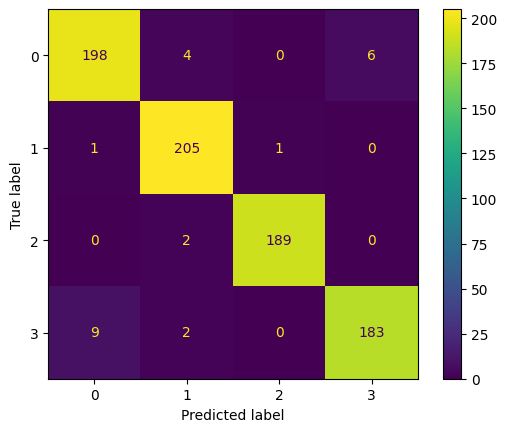

In [17]:
correct=0

SVM_MODEL = pickle.load(open('sift_classifier.pkl', 'rb'))
labels_predicted=[]
for i,img in enumerate(X_test):
      test=sift(img)
      label=SVM_MODEL.predict([test])
      labels_predicted.append(label)
      if(label==y_test[i]):
            correct+=1

print(correct/len(X_test)*100)

confusion_matrix = metrics.confusion_matrix(y_test, labels_predicted)



cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1,2,3])

cm_display.plot()
plt.show()